### 予測モデルの仕組みをわかりやすく説明します！

#### どんなことを予測するの？
このモデルは、**「当月末の限界利益がどのくらいになりそうか」**を、日次のデータを使って予測するものです。

#### どうやって予測するの？

1.  **日次のデータを使うよ！**
    *   毎日の限界利益データ（「MP」という名前だよ）と、確定値、A、B、C、Dの値を使います。
    *   これらのデータから、「当月末にどれくらいの限界利益があるか」のヒントを探すんだ。

2.  **２つの限界利益を足し算するよ！**
    当月末の限界利益を予測するとき、大きく分けて２つの部分に分けて考えます。

    *   **「もう決まっている限界利益（Confirmed）」**:
        これは、「確定MP」と「AMP（A）」を合わせた限界利益です。これはほぼ確実に手に入る限界利益だね！

    *   **「これから増えそうな限界利益（Additional）」**:
        これは、「まだ確定していないけど、これまでの経験から考えると、これくらいは増えそうだね」という限界利益です。
        この部分を予測するために、特別な計算を使います。特に「BCD」という種類の限界利益（「B」「C」「D」という３つの種類の限界利益を足したものだよ）が、どのくらい「これから増えそうな限界利益」に変わるかを過去のデータから学ぶんだ。

3.  **合計するよ！**
    最後に、「もう決まっている限界利益」と「これから増えそうな限界利益」を足し合わせると、当月末の限界利益の予測が出てきます。

#### まとめると...

このモデルは、日次の限界利益データ（確定値、A、B、C、D）を使って、**「すでに決まっている限界利益」**と**「過去の傾向から見て、これから増えそうな限界利益」**を別々に計算し、それらを合計することで、**「当月末の限界利益がどのくらいになりそうか」**を教えてくれる賢い予測屋さんなんです！

### 予測モデルの仕組みをもう少し詳しく説明します！

先ほどは、当月末の限界利益を「もう決まっている限界利益」と「これから増えそうな限界利益」の2つに分けて考えると説明しましたね。

「これから増えそうな限界利益（Additional）」を予測するために、このモデルでは主に2つの方法を使っています。

#### 1. 「ランダムフォレスト」という賢い予測屋さん

*   **ランダムフォレストって何？**
    これは、たくさんの小さな「予測の木」を集めて、みんなで相談して答えを出すようなものです。例えば、「この状況なら限界利益がこれくらい増えるんじゃない？」という予測を、それぞれが考えて、最後に一番良い答えを決めるイメージです。

*   **どうやって使うの？**
    過去のデータ（特に「B」「C」「D」といった種類の限界利益や、それが何月の何日目に起こったか）をこのたくさんの「予測の木」たちに教えてあげます。すると、「B」がいくらで「C」がいくらで「D」がいくらで、何月の何日目だったら、どれくらい「これから増えそうな限界利益」になるかを賢く予測してくれるんです。

#### 2. 「月別・日別の転換率」で予測

*   **転換率って何？**
    これは、「これくらいの限界利益（BCD）があったら、過去の経験から見て、だいたい何パーセントくらいが当月末に実際に限界利益になるだろう？」という割合のことです。

*   **どうやって使うの？**
    例えば、「1月の15日だったら、BCDの限界利益があったら過去のデータではだいたい70%が『これから増えそうな限界利益』になっていたな」というように、月ごと・日ごとにその割合（転換率）を計算しておきます。
    そして、新しい予測をするときには、その月とその日の転換率を使って「これくらいは増えるだろう」と予測します。

#### 最終的な予測

このモデルでは、この「ランダムフォレスト」の予測と「月別・日別の転換率」を使った予測を、良いバランスで組み合わせています。こうすることで、片方だけの予測よりも、もっと正確な「これから増えそうな限界利益」を出すことができるんですよ。

これに「もう決まっている限界利益」を足し合わせることで、当月末の限界利益を最終的に予測しています。

# MP Current Month-End Prediction Model
## 日次データから当月末MP予測モデル

## 1. ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print('Libraries loaded!')

Libraries loaded!


## 2. データの読み込み

In [2]:
try:
    from google.colab import files
    print('Upload CSV file:')
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
except:
    filename = 'progress_data.csv'
    print(f'Using: {filename}')

Upload CSV file:


Saving 進捗データ(新)_2026020317540815025.csv to 進捗データ(新)_2026020317540815025.csv


In [3]:
try:
    df = pd.read_csv(filename, encoding='utf-8-sig')
except:
    df = pd.read_csv(filename, encoding='shift_jis')

print(f'Shape: {df.shape}')
print(f'Columns: {df.columns.tolist()}')
df.head()

Shape: (2144, 13)
Columns: ['行ラベル', '合計 / MP', '合計 / 確定MP', '合計 / AMP', '合計 / BMP', '合計 / CMP', '合計 / DMP', '合計 / 次月MP', '合計 / 次月確定MP', '合計 / 次月AMP', '合計 / 次月BMP', '合計 / 次月CMP', '合計 / 次月DMP']


,行ラベル,合計 / MP,合計 / 確定MP,合計 / AMP,合計 / BMP,合計 / CMP,合計 / DMP,合計 / 次月MP,合計 / 次月確定MP,合計 / 次月AMP,合計 / 次月BMP,合計 / 次月CMP,合計 / 次月DMP
0,2020/04/01,52612321,3560426,49051895,9945801,6513693,24336375,15815626,0,15815626,1787889,2610055,58101088
1,2020/04/02,56827598,3851781,52975817,7023531,5452199,22024972,16514617,0,16514617,2656829,3009163,54178242
2,2020/04/03,58726803,5588962,53137841,5750444,5316388,19336368,16344677,0,16344677,3487701,3368643,50733450
3,2020/04/04,58726803,5588962,53137841,5750444,5316388,19336368,16344677,0,16344677,3487701,3368643,50733450
4,2020/04/05,59218260,5742347,53475913,5744476,5316685,19336368,16523619,0,16523619,3487701,4072319,50733450


## 3. データ前処理（日次データを使用）

In [4]:
# 元のカラム名を保存
original_columns = df.columns.tolist()
print(f'Original columns: {original_columns}')

# 日付処理
df['date'] = pd.to_datetime(df.iloc[:, 0], errors='coerce')
# NaT（無効な日付）を含む行を削除
df = df.dropna(subset=['date']).copy()

# 年月情報を追加
df['year_month'] = df['date'].dt.to_period('M')
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

print(f'\nDaily data points: {len(df)}')

Original columns: ['行ラベル', '合計 / MP', '合計 / 確定MP', '合計 / AMP', '合計 / BMP', '合計 / CMP', '合計 / DMP', '合計 / 次月MP', '合計 / 次月確定MP', '合計 / 次月AMP', '合計 / 次月BMP', '合計 / 次月CMP', '合計 / 次月DMP']

Daily data points: 2144


In [5]:
# カラム名を変更（確定、A、B、C、Dに対応）
col_mapping = {
    original_columns[1]: 'MP',
    original_columns[2]: 'Kakutei',  # 確定MP
    original_columns[3]: 'A',        # AMP
    original_columns[4]: 'B',        # BMP
    original_columns[5]: 'C',        # CMP
    original_columns[6]: 'D'         # DMP
}
print(f'Mapping: {col_mapping}')

df = df.rename(columns=col_mapping)

# 数値変換
for col in ['MP', 'Kakutei', 'A', 'B', 'C', 'D']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f'\nColumns after mapping: {df.columns.tolist()}')
df.head()

Mapping: {'合計 / MP': 'MP', '合計 / 確定MP': 'Kakutei', '合計 / AMP': 'A', '合計 / BMP': 'B', '合計 / CMP': 'C', '合計 / DMP': 'D'}

Columns after mapping: ['行ラベル', 'MP', 'Kakutei', 'A', 'B', 'C', 'D', '合計 / 次月MP', '合計 / 次月確定MP', '合計 / 次月AMP', '合計 / 次月BMP', '合計 / 次月CMP', '合計 / 次月DMP', 'date', 'year_month', 'month', 'day']


,行ラベル,MP,Kakutei,A,B,C,D,合計 / 次月MP,合計 / 次月確定MP,合計 / 次月AMP,合計 / 次月BMP,合計 / 次月CMP,合計 / 次月DMP,date,year_month,month,day
0,2020/04/01,52612321,3560426,49051895,9945801,6513693,24336375,15815626,0,15815626,1787889,2610055,58101088,2020-04-01,2020-04,4,1
1,2020/04/02,56827598,3851781,52975817,7023531,5452199,22024972,16514617,0,16514617,2656829,3009163,54178242,2020-04-02,2020-04,4,2
2,2020/04/03,58726803,5588962,53137841,5750444,5316388,19336368,16344677,0,16344677,3487701,3368643,50733450,2020-04-03,2020-04,4,3
3,2020/04/04,58726803,5588962,53137841,5750444,5316388,19336368,16344677,0,16344677,3487701,3368643,50733450,2020-04-04,2020-04,4,4
4,2020/04/05,59218260,5742347,53475913,5744476,5316685,19336368,16523619,0,16523619,3487701,4072319,50733450,2020-04-05,2020-04,4,5


In [6]:
# 各月の月末MPを取得（ターゲット変数として使用）
month_end_mp = df.groupby('year_month')['MP'].last().to_dict()

# 日次データに当月末MPを追加
df['Current_Month_End_MP'] = df['year_month'].map(month_end_mp)

# 訓練データ作成（月末以外の日のデータを使用）
# 月末は除外（予測対象なので）
month_end_dates = df.groupby('year_month')['date'].max()
df['is_month_end'] = df.apply(lambda x: x['date'] == month_end_dates[x['year_month']], axis=1)

# 訓練データ：月末を除く日次データ
train_data = df[~df['is_month_end']].copy()

print(f'Training data points: {len(train_data)} days')
print(f'Unique months: {train_data["year_month"].nunique()}')

if len(train_data) > 0:
    train_data['Confirmed'] = train_data['Kakutei'] + train_data['A']
    train_data['Additional'] = train_data['Current_Month_End_MP'] - train_data['Confirmed']
    train_data['BCD_Total'] = train_data['B'] + train_data['C'] + train_data['D']

    # 転換率計算（BCDがAdditionalにどれくらい変わるか）
    train_data['Conversion_Rate'] = np.where(
        train_data['BCD_Total'] > 0,
        train_data['Additional'] / train_data['BCD_Total'] * 100,
        0
    )

    print('Calculations complete!')
    print(train_data[['date', 'MP', 'Confirmed', 'BCD_Total', 'Current_Month_End_MP']].head(10))
else:
    print('ERROR: No training data!')

Training data points: 2073 days
Unique months: 71
Calculations complete!
        date        MP  Confirmed  BCD_Total  Current_Month_End_MP
0 2020-04-01  52612321   52612321   40795869              74015901
1 2020-04-02  56827598   56827598   34500702              74015901
2 2020-04-03  58726803   58726803   30403200              74015901
3 2020-04-04  58726803   58726803   30403200              74015901
4 2020-04-05  59218260   59218260   30397529              74015901
5 2020-04-06  59814329   59814329   29095305              74015901
6 2020-04-07  60803674   60803674   28307761              74015901
7 2020-04-08  62530730   62530730   27657544              74015901
8 2020-04-09  62668027   62668027   24550128              74015901
9 2020-04-10  61941369   61941369   17523156              74015901


## 4. 月別・日別転換率の分析

In [7]:
# 月別転換率
monthly_stats = train_data.groupby('month').agg({
    'Conversion_Rate': ['mean', 'std', 'count']
}).round(1)
monthly_stats.columns = ['Avg_Rate', 'Std', 'Count']

print('Monthly BCD Conversion Rate')
print('='*50)
month_names = ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for m in range(1, 13):
    if m in monthly_stats.index:
        r = monthly_stats.loc[m]
        print(f'{m:2d} ({month_names[m]}): {r["Avg_Rate"]:5.1f}% (n={int(r["Count"])})')

display(monthly_stats)

Monthly BCD Conversion Rate
 1 (Jan): 105.6% (n=180)
 2 (Feb):  63.9% (n=147)
 3 (Mar): 175.8% (n=150)
 4 (Apr):  93.8% (n=174)
 5 (May): 207.7% (n=180)
 6 (Jun): 169.3% (n=174)
 7 (Jul): 137.3% (n=180)
 8 (Aug): 134.9% (n=180)
 9 (Sep): 149.9% (n=174)
10 (Oct): 155.6% (n=180)
11 (Nov): 106.8% (n=174)
12 (Dec): 322.8% (n=180)


,Avg_Rate,Std,Count
month,,,
1,105.6,147.4,180
2,63.9,98.5,147
3,175.8,335.2,150
4,93.8,129.8,174
5,207.7,771.9,180
6,169.3,306.5,174
7,137.3,230.8,180
8,134.9,294.1,180
9,149.9,365.1,174


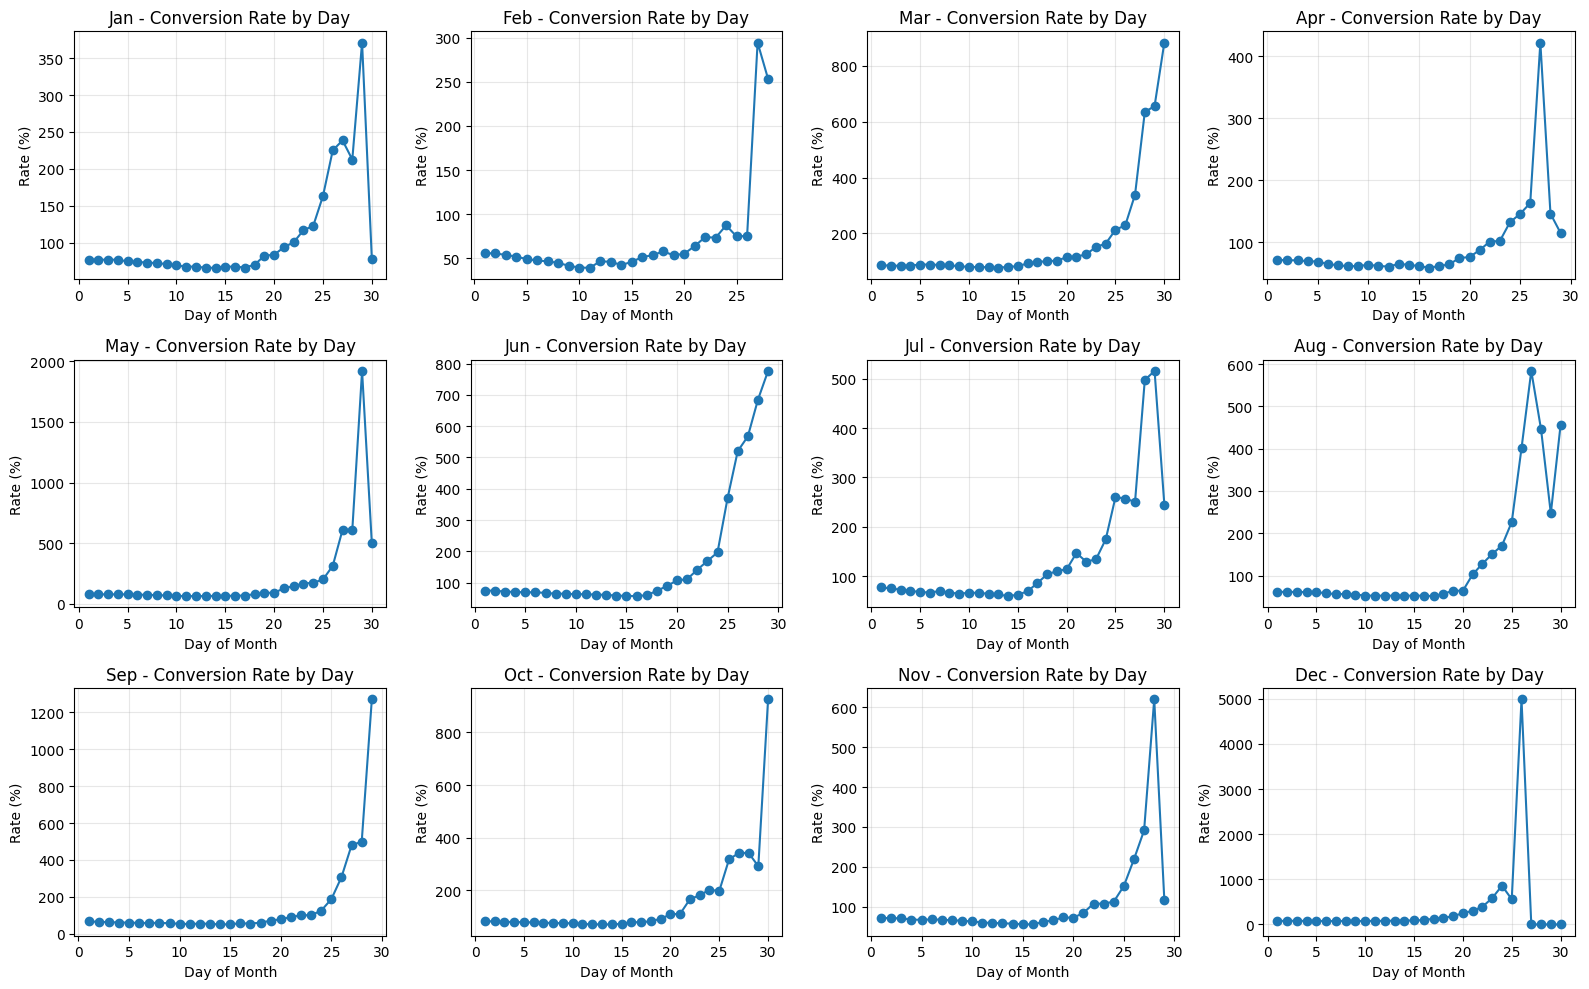

In [8]:
# 月内の日による転換率の変化を可視化
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

for m in range(1, 13):
    month_data = train_data[train_data['month'] == m]
    if len(month_data) > 0:
        daily_avg = month_data.groupby('day')['Conversion_Rate'].mean()
        axes[m-1].plot(daily_avg.index, daily_avg.values, marker='o')
        axes[m-1].set_title(f'{month_names[m]} - Conversion Rate by Day')
        axes[m-1].set_xlabel('Day of Month')
        axes[m-1].set_ylabel('Rate (%)')
        axes[m-1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. モデル構築

In [9]:
class CurrentMonthMPPredictor:
    def __init__(self):
        self.model = None
        self.monthly_rates = {}
        self.overall_avg_rate = None

    def train(self, data):
        # 月別平均転換率を計算
        for m in range(1, 13):
            sub = data[data['month'] == m]
            if len(sub) > 0:
                self.monthly_rates[m] = sub['Conversion_Rate'].mean()
        self.overall_avg_rate = data['Conversion_Rate'].mean()

        # Random Forestモデルの訓練
        # 特徴量: B、C、D、月、日
        X = data[['B', 'C', 'D', 'month', 'day']]
        y = data['Additional']

        self.model = RandomForestRegressor(
            n_estimators=100,
            max_depth=7,  # 深さを増やして日次データの複雑さに対応
            random_state=42
        )
        self.model.fit(X, y)

        # モデル評価
        pred_additional = self.model.predict(X)
        pred = data['Confirmed'] + pred_additional

        return {
            'mae': mean_absolute_error(data['Current_Month_End_MP'], pred),
            'r2': r2_score(data['Current_Month_End_MP'], pred)
        }

    def predict(self, kakutei, a, b, c, d, month, day):
        """日次の確定値、A、B、C、Dから当月末のMPを予測"""
        confirmed = kakutei + a
        bcd = b + c + d

        # Random Forestによる予測
        add_rf = self.model.predict([[b, c, d, month, day]])[0]

        # 月別転換率による予測
        rate = self.monthly_rates.get(month, self.overall_avg_rate) / 100
        add_rate = bcd * rate

        # ハイブリッド予測（RF 70% + 転換率 30%）
        additional = add_rf * 0.7 + add_rate * 0.3

        return {
            'month': month,
            'day': day,
            'confirmed': confirmed,
            'additional': additional,
            'forecast': confirmed + additional,
            'bcd': bcd,
            'rate': rate * 100
        }

print('CurrentMonthMPPredictor defined!')

CurrentMonthMPPredictor defined!


In [10]:
predictor = CurrentMonthMPPredictor()
metrics = predictor.train(train_data)

print('Model Trained!')
print(f'MAE: {metrics["mae"]/10000:,.0f} (10K JPY)')
print(f'R2:  {metrics["r2"]:.3f}')

Model Trained!
MAE: 134 (10K JPY)
R2:  0.980


## 6. 予測実行

In [11]:
def show_prediction(p):
    mn = ['','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    print('='*50)
    print(f'{mn[p["month"]]} Day {p["day"]} -> Month-End Forecast')
    print('='*50)
    print(f'Confirmed:  {p["confirmed"]/10000:>10,.0f} (10K)')
    print(f'Additional: {p["additional"]/10000:>10,.0f} (10K)')
    print(f'FORECAST:   {p["forecast"]/10000:>10,.0f} (10K)')
    print(f'Conv Rate: {p["rate"]:.1f}%')
    print('='*50)

In [12]:
# 最新データで予測
latest = df[~df['is_month_end']].iloc[-1]
print(f'Latest: {latest["date"].strftime("%Y-%m-%d")}')

p = predictor.predict(
    latest['Kakutei'], latest['A'],
    latest['B'], latest['C'], latest['D'],
    month=int(latest['month']),
    day=int(latest['day'])
)
show_prediction(p)

# 実際の月末MPと比較
actual_month_end = latest['Current_Month_End_MP']
print(f'\nActual Month-End MP: {actual_month_end/10000:>10,.0f} (10K)')
print(f'Prediction Error: {abs(p["forecast"] - actual_month_end)/10000:>10,.0f} (10K)')

Latest: 2026-02-11
Feb Day 11 -> Month-End Forecast
Confirmed:       6,282 (10K)
Additional:        659 (10K)
FORECAST:        6,941 (10K)
Conv Rate: 63.9%

Actual Month-End MP:      6,333 (10K)
Prediction Error:        609 (10K)


In [13]:
# カスタム予測例
# 例: 2月15日時点のデータから2月末を予測
p = predictor.predict(
    kakutei=609289,
    a=47905097,
    b=5236622,
    c=3481478,
    d=18589534,
    month=2,  # 2月
    day=15    # 15日
)
show_prediction(p)

Feb Day 15 -> Month-End Forecast
Confirmed:       4,851 (10K)
Additional:      1,461 (10K)
FORECAST:        6,312 (10K)
Conv Rate: 63.9%


## 7. 月内予測精度の推移

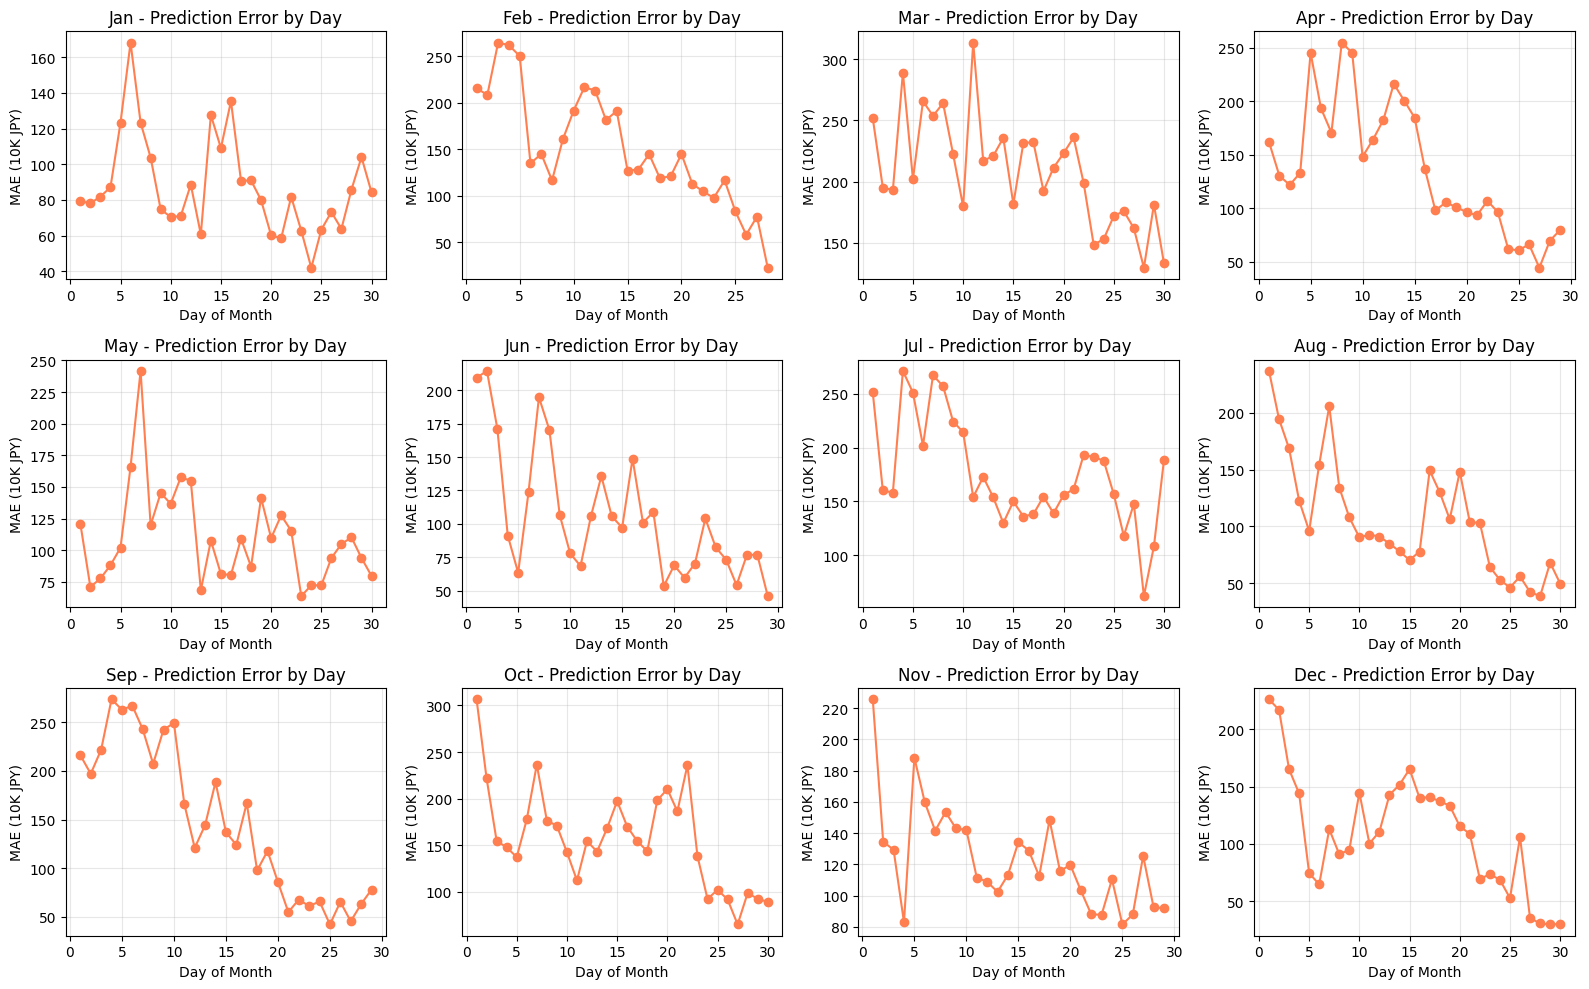

In [14]:
# 各月の日ごとの予測精度を分析
predictions_df = train_data.copy()
X_pred = predictions_df[['B', 'C', 'D', 'month', 'day']]
predictions_df['Predicted_Additional'] = predictor.model.predict(X_pred)
predictions_df['Predicted_Month_End_MP'] = predictions_df['Confirmed'] + predictions_df['Predicted_Additional']
predictions_df['Prediction_Error'] = abs(predictions_df['Predicted_Month_End_MP'] - predictions_df['Current_Month_End_MP'])

# 月別の予測誤差推移を可視化
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()
month_names = ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for m in range(1, 13):
    month_data = predictions_df[predictions_df['month'] == m]
    if len(month_data) > 0:
        daily_error = month_data.groupby('day')['Prediction_Error'].mean() / 10000
        axes[m-1].plot(daily_error.index, daily_error.values, marker='o', color='coral')
        axes[m-1].set_title(f'{month_names[m]} - Prediction Error by Day')
        axes[m-1].set_xlabel('Day of Month')
        axes[m-1].set_ylabel('MAE (10K JPY)')
        axes[m-1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. 実績値と予測値の比較

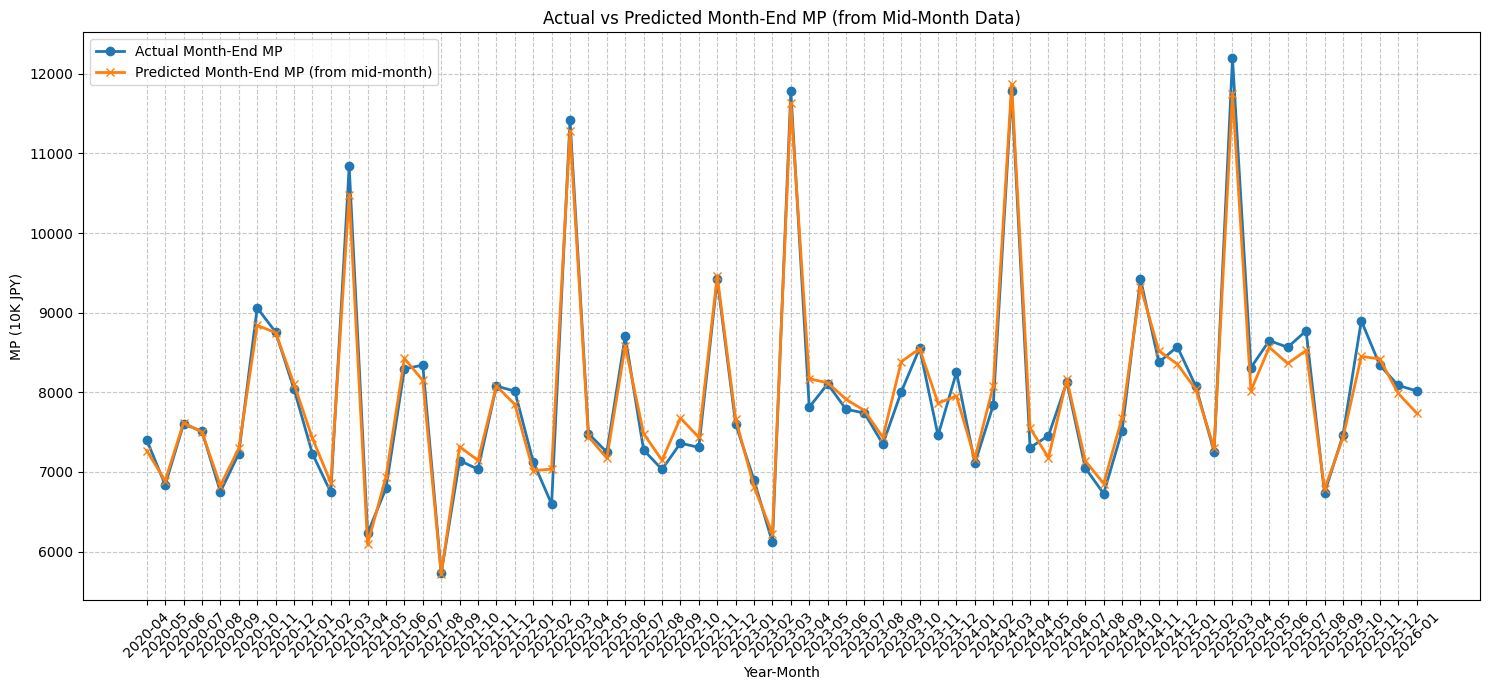


Mid-Month Prediction Statistics:
MAE: 148 (10K JPY)
Max Error: 448 (10K JPY)
Min Error: 2 (10K JPY)


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# サンプルとして各月の中旬（15日前後）のデータを抽出して比較
mid_month_data = predictions_df[predictions_df['day'].between(14, 16)].copy()
mid_month_data = mid_month_data.groupby('year_month').first().reset_index()

plt.figure(figsize=(15, 7))
plt.plot(mid_month_data['year_month'].astype(str),
         mid_month_data['Current_Month_End_MP']/10000,
         label='Actual Month-End MP', marker='o', linewidth=2)
plt.plot(mid_month_data['year_month'].astype(str),
         mid_month_data['Predicted_Month_End_MP']/10000,
         label='Predicted Month-End MP (from mid-month)', marker='x', linewidth=2)

plt.title('Actual vs Predicted Month-End MP (from Mid-Month Data)')
plt.xlabel('Year-Month')
plt.ylabel('MP (10K JPY)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# 統計情報
print('\nMid-Month Prediction Statistics:')
print(f'MAE: {mid_month_data["Prediction_Error"].mean()/10000:,.0f} (10K JPY)')
print(f'Max Error: {mid_month_data["Prediction_Error"].max()/10000:,.0f} (10K JPY)')
print(f'Min Error: {mid_month_data["Prediction_Error"].min()/10000:,.0f} (10K JPY)')

## 9. 月内の日ごとのシミュレーション

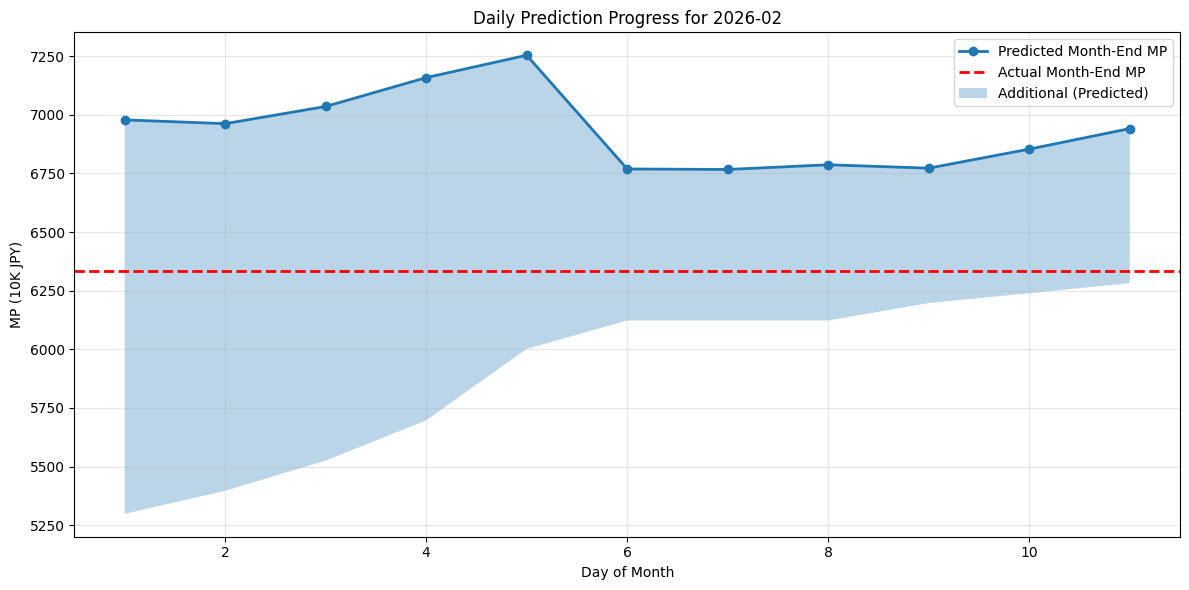


Daily Prediction Summary:


,day,confirmed,additional,forecast,actual
0,1,52982968,1.680184e+07,6.978481e+07,63326248
1,2,53964497,1.565900e+07,6.962350e+07,63326248
2,3,55253128,1.510346e+07,7.035659e+07,63326248
3,4,56968796,1.461819e+07,7.158699e+07,63326248
4,5,60018938,1.252229e+07,7.254123e+07,63326248
5,6,61227994,6.463052e+06,6.769105e+07,63326248
6,7,61227994,6.441489e+06,6.766948e+07,63326248
7,8,61227994,6.642413e+06,6.787041e+07,63326248
8,9,61972860,5.752076e+06,6.772494e+07,63326248
9,10,62391313,6.145827e+06,6.853714e+07,63326248


In [16]:
# 特定の月のデータを使って、日ごとの予測がどう変化するかシミュレーション
latest_month = df[df['year_month'] == df['year_month'].max()].copy()
latest_month = latest_month[~latest_month['is_month_end']]

if len(latest_month) > 0:
    simulation_results = []

    for _, row in latest_month.iterrows():
        p = predictor.predict(
            row['Kakutei'], row['A'],
            row['B'], row['C'], row['D'],
            month=int(row['month']),
            day=int(row['day'])
        )
        simulation_results.append({
            'date': row['date'],
            'day': row['day'],
            'confirmed': p['confirmed'],
            'additional': p['additional'],
            'forecast': p['forecast'],
            'actual': row['Current_Month_End_MP']
        })

    sim_df = pd.DataFrame(simulation_results)

    # 可視化
    plt.figure(figsize=(12, 6))
    plt.plot(sim_df['day'], sim_df['forecast']/10000,
             label='Predicted Month-End MP', marker='o', linewidth=2)
    plt.axhline(y=sim_df['actual'].iloc[0]/10000,
                color='red', linestyle='--', label='Actual Month-End MP', linewidth=2)
    plt.fill_between(sim_df['day'],
                     sim_df['confirmed']/10000,
                     sim_df['forecast']/10000,
                     alpha=0.3, label='Additional (Predicted)')

    plt.title(f'Daily Prediction Progress for {latest_month.iloc[0]["year_month"]}')
    plt.xlabel('Day of Month')
    plt.ylabel('MP (10K JPY)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print('\nDaily Prediction Summary:')
    display(sim_df[['day', 'confirmed', 'additional', 'forecast', 'actual']].head(10))
else:
    print('No data available for simulation')

## 10. 過去の任意の月の推移分析（インタラクティブ）

In [17]:
# 利用可能な月のリストを表示
available_months = sorted(df['year_month'].unique())
print('利用可能な月のリスト:')
print('='*60)
for i, ym in enumerate(available_months, 1):
    print(f'{i:2d}. {ym}')

print(f'\n合計: {len(available_months)} ヶ月分のデータ')

利用可能な月のリスト:
 1. 2020-04
 2. 2020-05
 3. 2020-06
 4. 2020-07
 5. 2020-08
 6. 2020-09
 7. 2020-10
 8. 2020-11
 9. 2020-12
10. 2021-01
11. 2021-02
12. 2021-03
13. 2021-04
14. 2021-05
15. 2021-06
16. 2021-07
17. 2021-08
18. 2021-09
19. 2021-10
20. 2021-11
21. 2021-12
22. 2022-01
23. 2022-02
24. 2022-03
25. 2022-04
26. 2022-05
27. 2022-06
28. 2022-07
29. 2022-08
30. 2022-09
31. 2022-10
32. 2022-11
33. 2022-12
34. 2023-01
35. 2023-02
36. 2023-03
37. 2023-04
38. 2023-05
39. 2023-06
40. 2023-07
41. 2023-08
42. 2023-09
43. 2023-10
44. 2023-11
45. 2023-12
46. 2024-01
47. 2024-02
48. 2024-03
49. 2024-04
50. 2024-05
51. 2024-06
52. 2024-07
53. 2024-08
54. 2024-09
55. 2024-10
56. 2024-11
57. 2024-12
58. 2025-01
59. 2025-02
60. 2025-03
61. 2025-04
62. 2025-05
63. 2025-06
64. 2025-07
65. 2025-08
66. 2025-09
67. 2025-10
68. 2025-11
69. 2025-12
70. 2026-01
71. 2026-02

合計: 71 ヶ月分のデータ


分析対象: 2025-02
データポイント: 27 日分


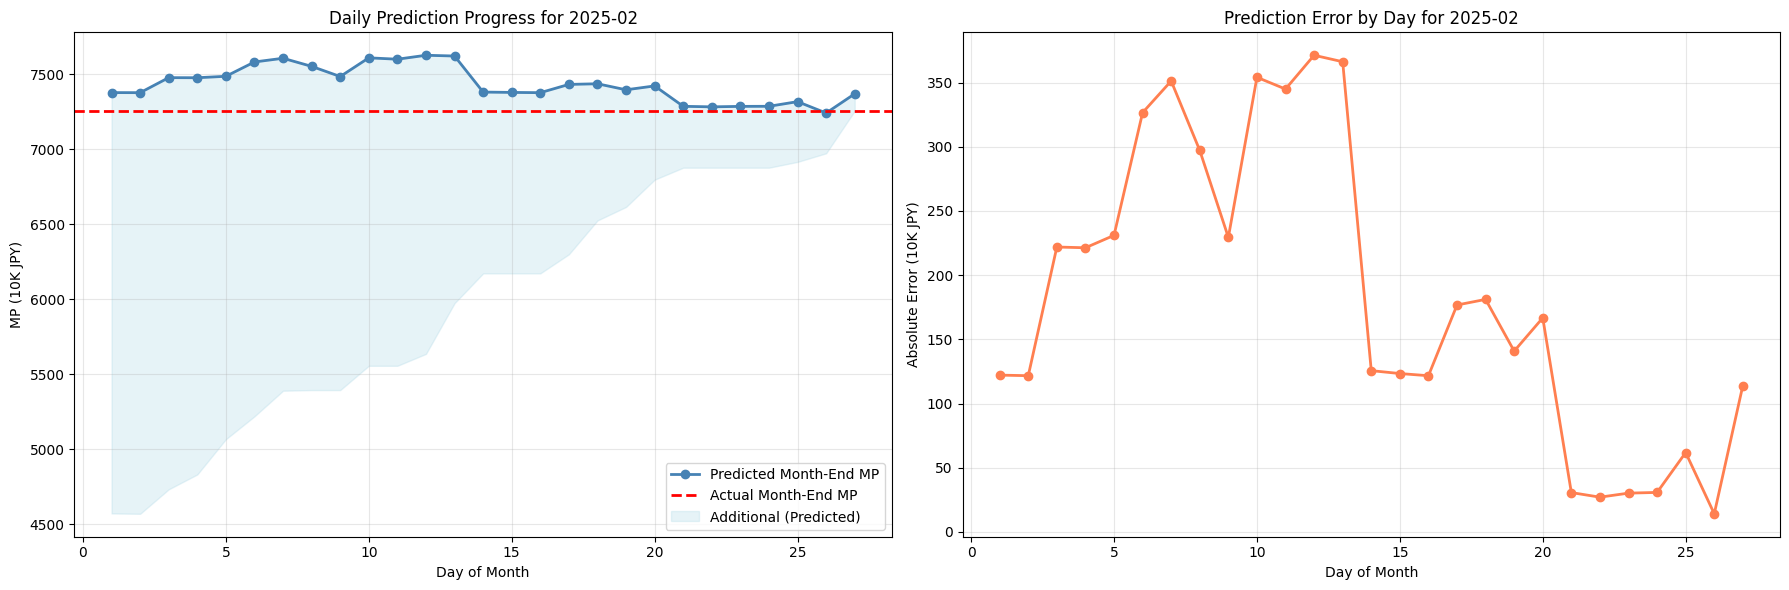


📊 予測統計:
実際の月末MP:            7,256 (10K JPY)
平均予測値:              7,437 (10K JPY)
最終日の予測値:          7,370 (10K JPY)
平均誤差 (MAE):            182 (10K JPY)
最大誤差:                  371 (10K JPY)
最小誤差:                   14 (10K JPY)

📅 日別予測サマリー（最初の10日）:


,day,confirmed,additional,forecast,actual,error
0,1,45707007,2.807422e+07,7.378122e+07,72559726,122.149663
1,2,45682007,2.809474e+07,7.377675e+07,72559726,121.702465
2,3,47315428,2.746346e+07,7.477889e+07,72559726,221.915969
3,4,48306998,2.646597e+07,7.477297e+07,72559726,221.324632
4,5,50658911,2.421070e+07,7.486961e+07,72559726,230.988297
5,6,52184863,2.364045e+07,7.582532e+07,72559726,326.559102
6,7,53893168,2.217881e+07,7.607198e+07,72559726,351.225552
7,8,53935987,2.159503e+07,7.553102e+07,72559726,297.129352
8,9,53935987,2.091770e+07,7.485369e+07,72559726,229.396002
9,10,55555560,2.054509e+07,7.610065e+07,72559726,354.092230



📅 日別予測サマリー（最後の5日）:


,day,confirmed,additional,forecast,actual,error
22,23,68771670,4.090413e+06,7.286208e+07,72559726,30.235748
23,24,68771670,4.095951e+06,7.286762e+07,72559726,30.789549
24,25,69158981,4.019003e+06,7.317798e+07,72559726,61.825774
25,26,69732370,2.685907e+06,7.241828e+07,72559726,14.144878
26,27,72559726,1.140476e+06,7.370020e+07,72559726,114.047627


In [20]:
# 分析したい月を選択（例：2025年6月なら '2025-06'）
# 上のリストから選んでください
selected_month = '2025-02'  # ← ここを変更してください

# 選択した月のデータを取得
selected_month_period = pd.Period(selected_month, freq='M')
selected_data = df[df['year_month'] == selected_month_period].copy()
selected_data = selected_data[~selected_data['is_month_end']]

if len(selected_data) > 0:
    print(f'分析対象: {selected_month}')
    print(f'データポイント: {len(selected_data)} 日分')
    print('='*60)

    # 日ごとの予測を計算
    simulation_results = []

    for _, row in selected_data.iterrows():
        p = predictor.predict(
            row['Kakutei'], row['A'],
            row['B'], row['C'], row['D'],
            month=int(row['month']),
            day=int(row['day'])
        )
        simulation_results.append({
            'date': row['date'],
            'day': row['day'],
            'confirmed': p['confirmed'],
            'additional': p['additional'],
            'forecast': p['forecast'],
            'actual': row['Current_Month_End_MP']
        })

    sim_df = pd.DataFrame(simulation_results)

    # グラフを2つ作成
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # グラフ1: 予測値の推移
    ax1.plot(sim_df['day'], sim_df['forecast']/10000,
             label='Predicted Month-End MP', marker='o', linewidth=2, color='steelblue')
    ax1.axhline(y=sim_df['actual'].iloc[0]/10000,
                color='red', linestyle='--', label='Actual Month-End MP', linewidth=2)
    ax1.fill_between(sim_df['day'],
                     sim_df['confirmed']/10000,
                     sim_df['forecast']/10000,
                     alpha=0.3, label='Additional (Predicted)', color='lightblue')
    ax1.set_title(f'Daily Prediction Progress for {selected_month}')
    ax1.set_xlabel('Day of Month')
    ax1.set_ylabel('MP (10K JPY)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # グラフ2: 予測誤差の推移
    sim_df['error'] = abs(sim_df['forecast'] - sim_df['actual']) / 10000
    ax2.plot(sim_df['day'], sim_df['error'],
             marker='o', linewidth=2, color='coral')
    ax2.set_title(f'Prediction Error by Day for {selected_month}')
    ax2.set_xlabel('Day of Month')
    ax2.set_ylabel('Absolute Error (10K JPY)')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 統計情報
    print('\n📊 予測統計:')
    print('='*60)
    print(f'実際の月末MP:     {sim_df["actual"].iloc[0]/10000:>12,.0f} (10K JPY)')
    print(f'平均予測値:       {sim_df["forecast"].mean()/10000:>12,.0f} (10K JPY)')
    print(f'最終日の予測値:   {sim_df["forecast"].iloc[-1]/10000:>12,.0f} (10K JPY)')
    print(f'平均誤差 (MAE):   {sim_df["error"].mean():>12,.0f} (10K JPY)')
    print(f'最大誤差:         {sim_df["error"].max():>12,.0f} (10K JPY)')
    print(f'最小誤差:         {sim_df["error"].min():>12,.0f} (10K JPY)')

    print('\n📅 日別予測サマリー（最初の10日）:')
    display(sim_df[['day', 'confirmed', 'additional', 'forecast', 'actual', 'error']].head(10))

    print('\n📅 日別予測サマリー（最後の5日）:')
    display(sim_df[['day', 'confirmed', 'additional', 'forecast', 'actual', 'error']].tail(5))

else:
    print(f'エラー: {selected_month} のデータが見つかりません。')
    print('上のリストから有効な年月を選んでください。')